In [12]:
import os
import numpy as np
import struct
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [2]:
# Функция для чтения файлов формата idx
def load_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Путь к папке с данными
data_path = './data2/'

In [3]:
# Загрузка данных
train_images = load_idx(os.path.join(data_path, 'train-images-idx3-ubyte'))
train_labels = load_idx(os.path.join(data_path, 'train-labels-idx1-ubyte'))
test_images = load_idx(os.path.join(data_path, 't10k-images-idx3-ubyte'))
test_labels = load_idx(os.path.join(data_path, 't10k-labels-idx1-ubyte'))

In [4]:
# Масштабирование изображений от 0 до 1
train_images = train_images / 255.0
test_images = test_images / 255.0

In [5]:
# Добавляем ось для каналов, чтобы использовать Conv2D
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

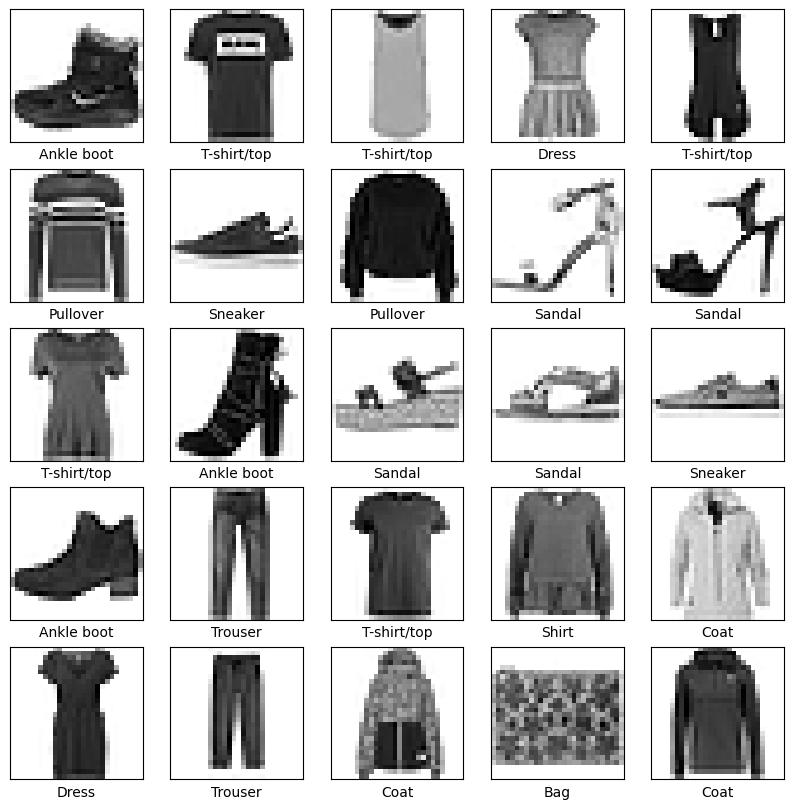

In [6]:
# Визуализация нескольких примеров из тренировочного набора
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [8]:
# Создание модели сверточной нейронной сети с использованием Input
model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),  # Указываем входную форму через Input
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

# Компиляция модели
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
# Обучение модели
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.7455 - loss: 0.7036 - val_accuracy: 0.8711 - val_loss: 0.3542
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.8789 - loss: 0.3329 - val_accuracy: 0.8806 - val_loss: 0.3321
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.8976 - loss: 0.2810 - val_accuracy: 0.8887 - val_loss: 0.3090
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9116 - loss: 0.2403 - val_accuracy: 0.8988 - val_loss: 0.2847
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9215 - loss: 0.2129 - val_accuracy: 0.9012 - val_loss: 0.2740
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9244 - loss: 0.2012 - val_accuracy: 0.9036 - val_loss: 0.2675
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9338 - loss: 0.1801 - val_accuracy: 0.9113 - val_loss: 0.2663
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9391 -

In [10]:
# Оценка модели
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nТочность на тестовых данных: {test_acc}')

313/313 - 1s - 4ms/step - accuracy: 0.9020 - loss: 0.2804

Точность на тестовых данных: 0.9020000100135803


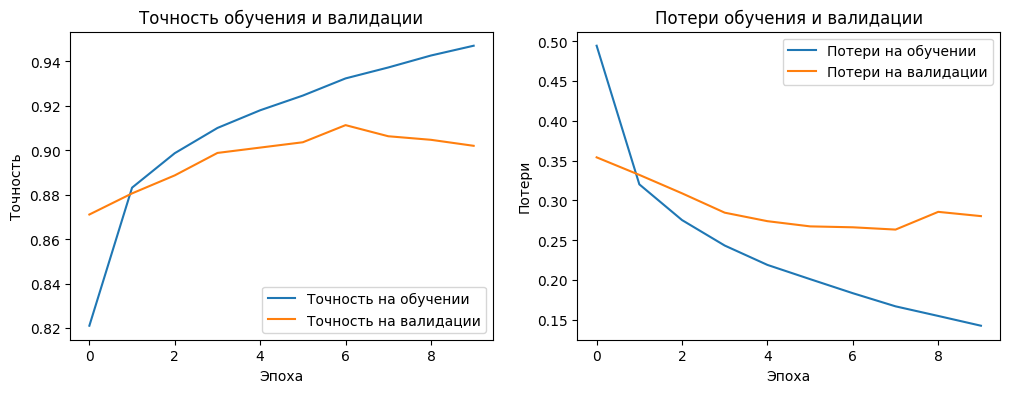

In [11]:
# Визуализация точности и потерь на этапах обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label = 'Точность на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend(loc='lower right')
plt.title('Точность обучения и валидации')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label = 'Потери на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend(loc='upper right')
plt.title('Потери обучения и валидации')
plt.show()

In [13]:
# Бинаризация меток для multi-class ROC
train_labels_bin = label_binarize(train_labels, classes=range(10))
test_labels_bin = label_binarize(test_labels, classes=range(10))
n_classes = train_labels_bin.shape[1]

# Предсказания на тестовых данных
y_score = model.predict(test_images)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [14]:
# ROC-кривые
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

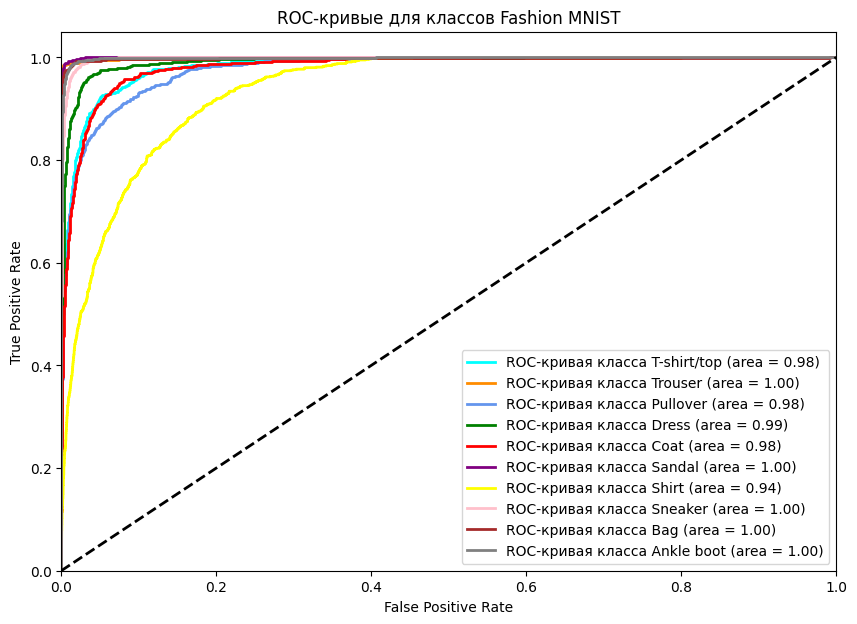

In [15]:
# Визуализация ROC-кривых для всех классов
plt.figure(figsize=(10, 7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow', 'pink', 'brown', 'gray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC-кривая класса {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для классов Fashion MNIST')
plt.legend(loc="lower right")
plt.show()

### Прогнозирование поведения потребителей (регрессия или классификация) датасет Online Retail
предсказание количества покупок на основе временных и категориальных признаков.


In [19]:
# Загрузка датасета Online Retail
data_path = './data1/Online Retail.xlsx'
online_retail = pd.read_excel(data_path)

In [20]:
# Предобработка данных
# Удаляем пропуски и выбрасываем строки с отрицательным количеством
online_retail = online_retail.dropna()
online_retail = online_retail[online_retail['Quantity'] > 0]

In [21]:
# Преобразование даты в формат datetime
online_retail['InvoiceDate'] = pd.to_datetime(online_retail['InvoiceDate'])

In [23]:
# Преобразование 'StockCode' в строковый формат для безопасного среза
online_retail['StockCode'] = online_retail['StockCode'].astype(str)

# Создание новой фичи 'Category' на основе первых двух символов StockCode
online_retail['Category'] = online_retail['StockCode'].apply(lambda x: x[:2])

# Создание новой фичи 'Month' на основе даты
online_retail['Month'] = online_retail['InvoiceDate'].dt.to_period('M')

<Figure size 1400x700 with 0 Axes>

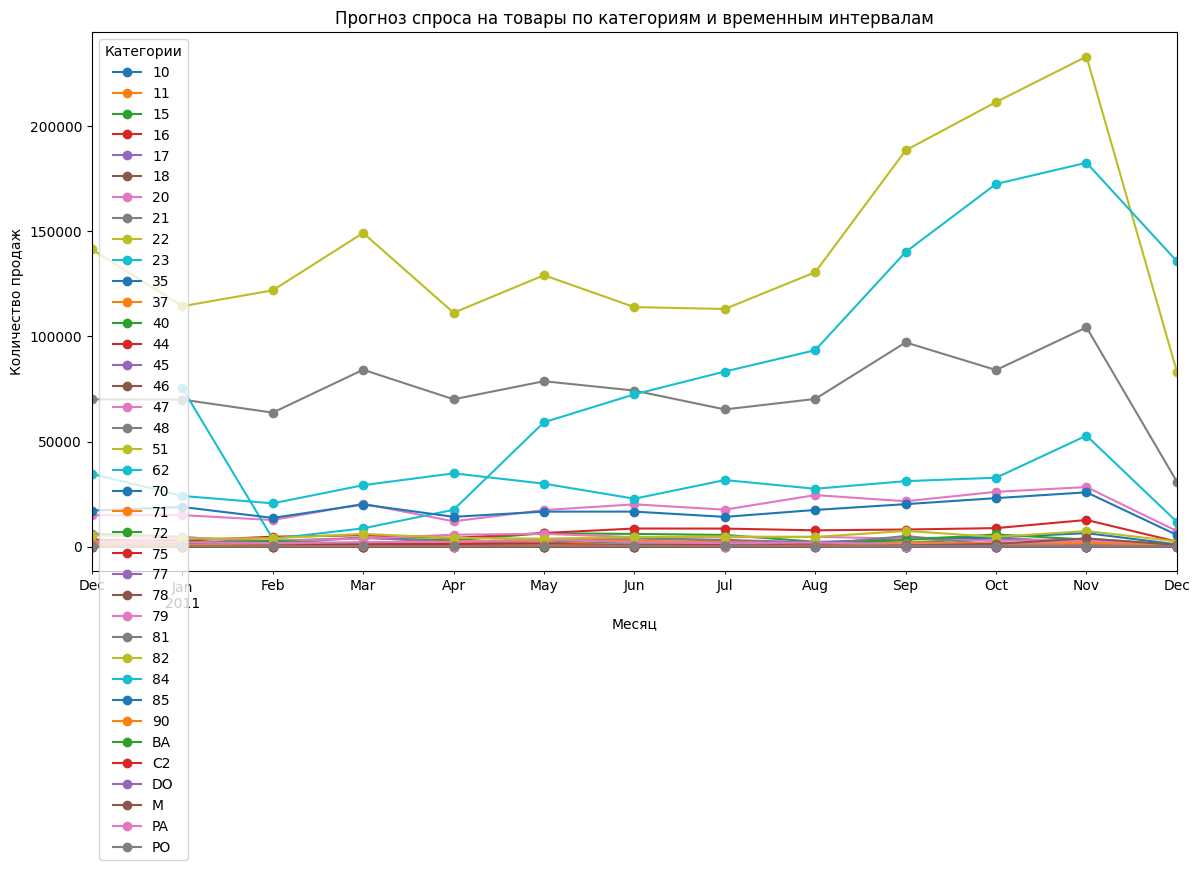

In [35]:
# Визуализация продаж по категориям и месяцам
category_sales = online_retail.groupby(['Month', 'Category'])['Quantity'].sum().unstack()

# Визуализация прогноза спроса на товары по категориям и временным интервалам
plt.figure(figsize=(14, 7))
category_sales.plot(kind='line', marker='o', figsize=(14,7))
plt.title('Прогноз спроса на товары по категориям и временным интервалам')
plt.xlabel('Месяц')
plt.ylabel('Количество продаж')
plt.legend(title='Категории')
plt.show()

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [40]:
# Загрузка данных
file_path = './data1/Online Retail.xlsx'
df = pd.read_excel(file_path)

In [41]:
# Предобработка данных
df = df.dropna(subset=['CustomerID', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice'])  # удаление пропусков

# Преобразование категорий в числовые значения
label_encoder = LabelEncoder()
df['CategoryEncoded'] = label_encoder.fit_transform(df['StockCode'].astype(str))

In [42]:
# Создание целевой переменной и признаков
X = df[['Quantity', 'UnitPrice']]  # признаки
y = df['CategoryEncoded']  # целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Обучение классификационной модели

In [43]:
# Обучение модели случайного леса
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Прогнозирование вероятностей для тестовой выборки
y_probs = model.predict_proba(X_test)

#### Построение ROC-кривой

In [52]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [53]:
# Бинаризируем целевую переменную для корректного построения ROC-кривой
y_train_binarized = label_binarize(y_train, classes=range(len(label_encoder.classes_)))
y_test_binarized = label_binarize(y_test, classes=range(len(label_encoder.classes_)))

In [56]:
# Уменьшаем размер выборки
X_train_sample = X_train[:10000]
y_train_sample = y_train_binarized[:10000]
X_test_sample = X_test[:10000]
y_test_sample = y_test_binarized[:10000]

In [57]:
# Используем OneVsRestClassifier с уменьшенным количеством деревьев и всеми ядрами процессора
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1))
classifier.fit(X_train_sample, y_train_sample)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 5 is present in all training examples.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklear

OneVsRestClassifier(estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                                     random_state=42))

In [58]:
# Прогноз вероятностей
y_probs = classifier.predict_proba(X_test_sample)

# Построение ROC-кривых для каждой категории
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_sample[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_r

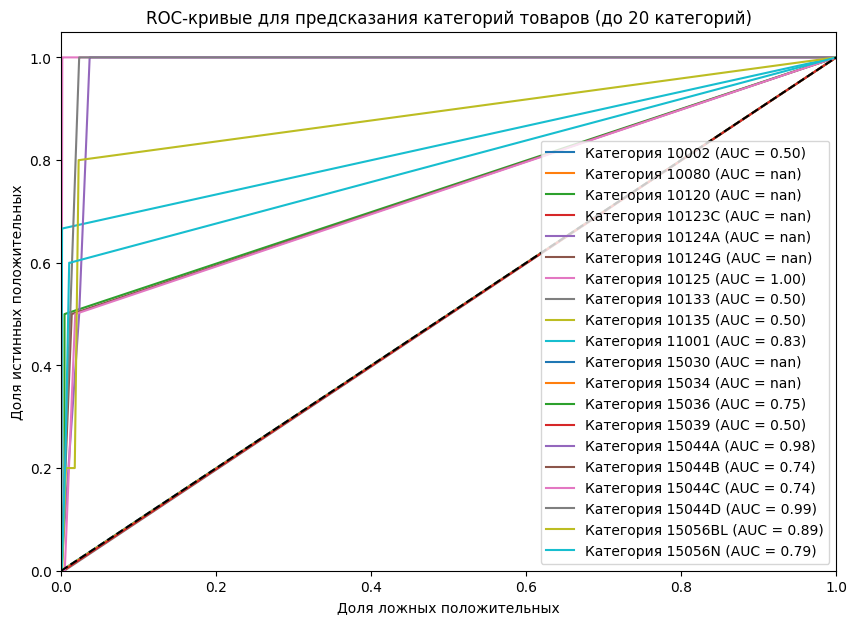

In [62]:
# Визуализация ROC-кривых
# Построение ROC-кривых для первых 20 категорий
plt.figure(figsize=(10, 7))
for i in range(min(20, len(label_encoder.classes_))):  # Ограничиваем до 10 категорий
    plt.plot(fpr[i], tpr[i], label=f'Категория {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Доля ложных положительных')
plt.ylabel('Доля истинных положительных')
plt.title('ROC-кривые для предсказания категорий товаров (до 20 категорий)')
plt.legend(loc="lower right")
plt.show()